# PlacesCNN for scene classification

by Nan BAI

adapted from the original code of Bolei Zhou, Dec.27, 2017

In [1]:
import torch
from torch.autograd import Variable as V
import torchvision.models as models
from torchvision import transforms as trn
from torch.nn import functional as F
import os
import numpy as np
import cv2
from PIL import Image
from PIL.ImageOps import colorize
import pandas as pd

In [2]:
print("PyTorch version {}".format(torch.__version__))
print("GPU-enabled installation? {}".format(torch.cuda.is_available()))

PyTorch version 1.10.2
GPU-enabled installation? True


In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [4]:
# hacky way to deal with the Pytorch 1.0 update
def recursion_change_bn(module):
    if isinstance(module, torch.nn.BatchNorm2d):
        module.track_running_stats = 1
    else:
        for i, (name, module1) in enumerate(module._modules.items()):
            module1 = recursion_change_bn(module1)
    return module

In [5]:
def load_labels():
    # prepare all the labels
    # scene category relevant
    file_name_category = 'categories_places365.txt'
    if not os.access(file_name_category, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt'
        os.system('wget ' + synset_url)
    classes = list()
    with open(file_name_category) as class_file:
        for line in class_file:
            classes.append(line.strip().split(' ')[0][3:])
    classes = tuple(classes)

    # indoor and outdoor relevant
    file_name_IO = 'IO_places365.txt'
    if not os.access(file_name_IO, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt'
        os.system('wget ' + synset_url)
    with open(file_name_IO) as f:
        lines = f.readlines()
        labels_IO = []
        for line in lines:
            items = line.rstrip().split()
            labels_IO.append(int(items[-1]) -1) # 0 is indoor, 1 is outdoor
    labels_IO = np.array(labels_IO)

    # scene attribute relevant
    file_name_attribute = 'labels_sunattribute.txt'
    if not os.access(file_name_attribute, os.W_OK):
        synset_url = 'https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt'
        os.system('wget ' + synset_url)
    with open(file_name_attribute) as f:
        lines = f.readlines()
        labels_attribute = [item.rstrip() for item in lines]
    file_name_W = 'W_sceneattribute_wideresnet18.npy'
    if not os.access(file_name_W, os.W_OK):
        synset_url = 'http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy'
        os.system('wget ' + synset_url)
    W_attribute = np.load(file_name_W)

    return classes, labels_IO, labels_attribute, W_attribute

In [6]:
def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

def returnTF():
# load the image transformer
    tf = trn.Compose([
        trn.Resize((224,224)),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return tf

In [7]:
def load_model():
    # this model has a last conv feature map as 14x14

    model_file = 'wideresnet18_places365.pth.tar'
    if not os.access(model_file, os.W_OK):
        os.system('wget http://places2.csail.mit.edu/models_places365/' + model_file)
        os.system('wget https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py')

    import wideresnet
    model = wideresnet.resnet18(num_classes=365)
    checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    
    # hacky way to deal with the upgraded batchnorm2D and avgpool layers...
    for i, (name, module) in enumerate(model._modules.items()):
        module = recursion_change_bn(model)
    model.avgpool = torch.nn.AvgPool2d(kernel_size=14, stride=1, padding=0)
    
    model.eval()



    # the following is deprecated, everything is migrated to python36

    ## if you encounter the UnicodeDecodeError when use python3 to load the model, add the following line will fix it. Thanks to @soravux
    #from functools import partial
    #import pickle
    #pickle.load = partial(pickle.load, encoding="latin1")
    #pickle.Unpickler = partial(pickle.Unpickler, encoding="latin1")
    #model = torch.load(model_file, map_location=lambda storage, loc: storage, pickle_module=pickle)

    #model.eval()
    # hook the feature extractor
    features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
    for name in features_names:
        model._modules.get(name).register_forward_hook(hook_feature)
    return model

In [8]:
# load the labels
classes, labels_IO, labels_attribute, W_attribute = load_labels()

# load the model
features_blobs = []
model = load_model()

# load the transformer
tf = returnTF() # image transformer

# get the softmax weight
params = list(model.parameters())
weight_softmax = params[-2].data.numpy()
weight_softmax[weight_softmax<0] = 0

In [13]:
W_attribute.shape

(102, 512)

In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=1)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=1)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=1)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=1)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn

In [10]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_make_layer',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_dict_hooks',
 '_version',
 'add_mod

In [9]:
labels_attribute

['boating',
 'driving',
 'biking',
 'transporting',
 'sunbathing',
 'touring',
 'hiking',
 'climbing',
 'camping',
 'reading',
 'studying',
 'training',
 'research',
 'diving',
 'swimming',
 'bathing',
 'eating',
 'cleaning',
 'socializing',
 'congregating',
 'waiting in line',
 'competing',
 'sports',
 'exercise',
 'playing',
 'gaming',
 'spectating',
 'farming',
 'constructing',
 'shopping',
 'medical activity',
 'working',
 'using tools',
 'digging',
 'conducting business',
 'praying',
 'fencing',
 'railing',
 'wire',
 'railroad',
 'trees',
 'grass',
 'vegetation',
 'shrubbery',
 'foliage',
 'leaves',
 'flowers',
 'asphalt',
 'pavement',
 'shingles',
 'carpet',
 'brick',
 'tiles',
 'concrete',
 'metal',
 'paper',
 'wood',
 'vinyl',
 'plastic',
 'cloth',
 'sand',
 'rock',
 'dirt',
 'marble',
 'glass',
 'surf',
 'ocean',
 'running water',
 'still water',
 'ice',
 'snow',
 'clouds',
 'smoke',
 'fire',
 'natural light',
 'sunny',
 'indoor lighting',
 'aged',
 'glossy',
 'matte',
 'steri

In [10]:
def load_images(images_folder):
    all_images = []
    for file in os.listdir(images_folder):
        if os.path.splitext(file)[1].lower() in ('.jpg', '.jpeg', '.png'):
            all_images.append(file)
    return all_images

In [11]:
def load_images_from_category_folders(images_folder):
    all_images = {}
    all_imgs = []
    categories = []
    category_dict = {}
    for file in os.listdir(images_folder):
        if os.path.isdir(images_folder + '/' + file):
            print(file)
            categories.append(file)
            category_dict[len(category_dict)] = file
            all_images[file] = []
            for f in os.listdir(images_folder + '/' + file):
                if os.path.splitext(f)[1].lower() in ('.jpg', '.jpeg', '.png'):
                    all_images[file].append(f)
                    all_imgs.append((f, file, len(categories)))
    return all_images, all_imgs, categories, category_dict

In [20]:
images_folder = 'data_storage/images/5km/150/'
all_images = load_images(images_folder)

In [694]:
images_folder_320 = 'data_storage/images/5km/320/'
all_images_320 = load_images(images_folder_320)

In [695]:
images_folder_150 = 'data_storage/images/5km/150/'
all_images_150 = load_images(images_folder_150)

In [20]:
images_folder_320 = 'Venezia/data_storage/images/320/'
all_images_320 = load_images(images_folder_320)

In [21]:
images_folder_150 = 'Venezia/data_storage/images/150/'
all_images_150 = load_images(images_folder_150)

In [66]:
images_folder_320_S = 'Suzhou/data_storage/images/320/'
all_images_320_S = load_images(images_folder_320_S)

In [67]:
images_folder_150_S = 'Suzhou/data_storage/images/150/'
all_images_150_S = load_images(images_folder_150_S)

In [12]:
images_folder_320_A = 'Amsterdam/data_storage/images/320/'
all_images_320_A = load_images(images_folder_320_A)

In [13]:
images_folder_150_A = 'Amsterdam/data_storage/images/150/'
all_images_150_A = load_images(images_folder_150_A)

In [13]:
images_folder_150_L = 'data_storage/images/grid-150/'
all_images_150_L = load_images(images_folder_150_L)

In [21]:
images_folder = 'data_storage/images/grid-150/'
all_images = load_images(images_folder)

In [47]:
images_folder_Tripoli = 'Tripoli/data_storage/images'
all_images_dict, all_images_Tripoli, categories, cat_dict = load_images_from_category_folders(images_folder_Tripoli)

architectural elements
form
gastronomy
interior
landscape scenery and natural features
monuments
people
product
urban scenery


In [14]:
def get_one_image(ID, all_images, images_folder):
    # load the test image
    if type(all_images[0]) is tuple:
        img_name = all_images[ID][0]
        img = Image.open(images_folder + '/' + all_images[ID][1] +'/'+img_name)
    else:
        img_name = all_images[ID]
        #os.system('wget %s -q -O test.jpg' % img_url)
        img = Image.open(images_folder + img_name)
    if img.mode == 'L':
        img = colorize(img, black=(0,0,0), white=(255,255,255))
    if img.mode == 'CMYK':
        img = img.convert('RGB')
    tf = returnTF()
    input_img = V(tf(img).unsqueeze(0))
    return img_name, img, input_img

In [15]:
def get_one_image_name(name, all_images, images_folder):
    if type(all_images[0]) is tuple:
        img_list = [a[0] for a in all_images]
        cat_list = [a[1] for a in all_images]
        assert name+'.jpg' in [a[0] for a in all_images]
        ID = img_list.index(name+'.jpg')
        img = Image.open(images_folder + '/' + cat_list[ID] +'/'+name+ '.jpg')
    else:
        assert name+'.jpg' in all_images
        img = Image.open(images_folder + name + '.jpg')
          
    if img.mode == 'L':
        img = colorize(img, black=(0,0,0), white=(255,255,255))
    input_img = V(tf(img).unsqueeze(0))
    return img, input_img

In [16]:
def process_one_image(input_img, model):
    # forward pass
    logit = model.forward(input_img)
    h_x = F.softmax(logit, 1).data.squeeze()
    probs, idx = h_x.sort(-1, True)
    probs = probs.numpy()
    idx = idx.numpy()
    
    return probs, idx

In [17]:
def report_one_image(input_img, model=model, features_blobs=features_blobs,
                    attr_num = 10, places_num = 10, W_attribute = W_attribute, classes=classes,
                     labels_attribute = labels_attribute, labels_IO=labels_IO):
    probs, idx= process_one_image(input_img, model)
    features_blobs = features_blobs[-2:]
    report = {}
    # output the IO prediction
    io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
    if io_image < 0.5:
        report['TYPE OF ENVIRONMENT']='indoor'
    else:
        report['TYPE OF ENVIRONMENT']='outdoor'
        
    # output the prediction of scene category    
    report['PRED'] = [(probs[i], classes[idx[i]], idx[i]) for i in range(0,places_num)]
    
    # output the scene attributes
    responses_attribute = W_attribute.dot(features_blobs[-1])
    #print(responses_attribute[0],len(responses_attribute), features_blobs[-1].shape)
    #print(responses_attribute.shape)
    idx_a = np.argsort(responses_attribute)
    report['SCENE ATTRIBUTES'] =[(labels_attribute[idx_a[i]],idx_a[i]) for i in range(-1,-1*attr_num-1,-1)]
    
    #output the image features
    report['FEATURES'] = features_blobs[-1]

    return report

In [18]:
def report_many_images(input_img, image_names, model=model, features_blobs=features_blobs,
                       attr_num = 10, places_num = 10, W_attribute = W_attribute, classes=classes,
                       labels_attribute = labels_attribute, labels_IO = labels_IO):
    if len(image_names)==1:
        return report_one_image(input_img, model=model, features_blobs=features_blobs,
                    attr_num = 10, places_num = 10, W_attribute = W_attribute, classes=classes,
                     labels_attribute = labels_attribute, labels_IO=labels_IO)
    
    probs, idx= process_one_image(input_img, model)
    features_blobs = features_blobs[-2:]
    all_report = {}
    
    for n in range(len(image_names)):
        report = {}
        # output the IO prediction
        io_image = np.mean(labels_IO[idx[n][:10]]) # vote for the indoor or outdoor
        if io_image < 0.5:
            report['TYPE OF ENVIRONMENT']='indoor'
        else:
            report['TYPE OF ENVIRONMENT']='outdoor'

        # output the prediction of scene category    
        report['PRED'] = [(probs[n][i], classes[idx[n][i]], idx[n][i]) for i in range(0,places_num)]

        # output the scene attributes
        responses_attribute = W_attribute.dot(features_blobs[-1][n])
        #print(len(responses_attribute[0]),len(responses_attribute), features_blobs[-1].shape)
        #print(responses_attribute.shape)
        idx_a = np.argsort(responses_attribute)
        #print(idx_a[0])
        report['SCENE ATTRIBUTES'] =[(labels_attribute[idx_a[i]],idx_a[i]) for i in range(-1,-1*attr_num-1,-1)]

        #output the image features
        report['FEATURES'] = features_blobs[-1][n]
        
        all_report[image_names[n]] = report

    return all_report

In [21]:
def report_image_i(ID=0, images_folder=images_folder, all_images=all_images, model=model, features_blobs=features_blobs, 
                   attr_num = 10, places_num = 10, classes=classes, labels_IO=labels_IO,
                   W_attribute = W_attribute, labels_attribute = labels_attribute):
    img_name, img, input_img = get_one_image(ID, all_images, images_folder)
    report = report_one_image(input_img, model=model, features_blobs=features_blobs,
                    attr_num = attr_num, places_num = places_num, W_attribute = W_attribute, classes=classes,
                    labels_attribute = labels_attribute, labels_IO=labels_IO)
    return report

In [22]:
def report_images(IDs=[0,1], images_folder=images_folder, all_images=all_images, model=model, features_blobs=features_blobs, 
                  attr_num = 10, places_num = 10, classes=classes, labels_IO=labels_IO,
                  W_attribute = W_attribute, labels_attribute = labels_attribute):
    image_names = [get_one_image(ID, all_images, images_folder)[0] for ID in IDs]
    input_img = torch.cat(tuple([get_one_image(ID, all_images, images_folder)[-1] for ID in IDs]))
    report = report_many_images(input_img, image_names, model=model, features_blobs=features_blobs,
                    attr_num = attr_num, places_num = places_num, W_attribute = W_attribute, classes=classes,
                    labels_attribute = labels_attribute, labels_IO=labels_IO)
    return report

In [23]:
def report_i_to_df(report):
        
    A_s = ['Attributes', 'Attributes_ID']

    a = pd.DataFrame(report['SCENE ATTRIBUTES']).T
    a0 = []
    for i in range(len(A_s)):
        aa = a.loc[i].reset_index()
        aa['index'] = A_s[i] + '_' + aa['index'].astype(str)
        aa = aa.set_index('index').rename(columns={i:'values'})
        a0.append(aa)

    B_s = ['Places_p', 'Places','Places_ID']

    b = pd.DataFrame(report['PRED']).T
    for i in range(len(B_s)):
        bb = b.loc[i].reset_index()
        bb['index'] = B_s[i] + '_' + bb['index'].astype(str)
        bb = bb.set_index('index').rename(columns={i:'values'})
        a0.append(bb)    

    c = pd.DataFrame(report['FEATURES'])
    c = c.reset_index()
    c['index'] = 'VisFeat_' + c['index'].astype(str)
    c = c.set_index('index').rename(columns={0:'values'})
    a0.append(c)

    d = pd.concat(a0).T

    d['IO_type'] = report['TYPE OF ENVIRONMENT']

    return d

In [24]:
def image_i_to_df(ID=0, images_folder=images_folder, all_images=all_images, model=model, features_blobs=features_blobs, 
                  attr_num = 10, places_num = 10, W_attribute = W_attribute, labels_attribute = labels_attribute,
                 classes=classes, labels_IO=labels_IO):
    report = report_image_i(ID, images_folder=images_folder, all_images=all_images, model=model, features_blobs=features_blobs, 
                   attr_num = attr_num, places_num = places_num, classes=classes, labels_IO=labels_IO,
                   W_attribute = W_attribute, labels_attribute = labels_attribute)
    df = report_i_to_df(report)
    return df

In [25]:
def images_to_df(IDs=[0,1], images_folder=images_folder, all_images=all_images, model=model, features_blobs=features_blobs, 
                  attr_num = 10, places_num = 10, W_attribute = W_attribute, labels_attribute = labels_attribute,
                 classes=classes, labels_IO=labels_IO):
    report = report_images(IDs, images_folder=images_folder, all_images=all_images, model=model, features_blobs=features_blobs, 
                  attr_num = attr_num, places_num = places_num, classes=classes, labels_IO=labels_IO,
                  W_attribute = W_attribute, labels_attribute = labels_attribute)
    image_names = report.keys()
    ls_df = []
    for n in range(len(IDs)):
        name = list(report.keys())[n]
        df = report_i_to_df(report[name])
        df['name'] = name
        df['ID'] = name[:-4]
        ls_df.append(df)
    df_all = pd.concat(ls_df, axis=0)
    df_all = df_all.set_index('ID')
    return df_all

In [26]:
def batch_df(images_folder=images_folder, all_images=all_images, batch_size = 8, model=model, features_blobs=features_blobs, 
                  attr_num = 10, places_num = 10, W_attribute = W_attribute, labels_attribute = labels_attribute,
                 classes=classes, labels_IO=labels_IO):
    size = len(all_images)
    batch_num = int(size/batch_size)
    ls_df = []
    for i in range(batch_num):
        IDs = list(range(batch_size*i, batch_size*(i+1)))
        temp_df = images_to_df(IDs, images_folder=images_folder, all_images=all_images, model=model, features_blobs=features_blobs, 
                  attr_num = attr_num, places_num = places_num, W_attribute = W_attribute, labels_attribute = labels_attribute,
                 classes=classes, labels_IO=labels_IO)
        ls_df.append(temp_df)
        print('{}/{} batches finished'.format(i+1, batch_num+1))
    IDs = list(range(batch_size*batch_num, size))
    temp_df = images_to_df(IDs, images_folder=images_folder, all_images=all_images, model=model, features_blobs=features_blobs, 
                  attr_num = attr_num, places_num = places_num, W_attribute = W_attribute, labels_attribute = labels_attribute,
                 classes=classes, labels_IO=labels_IO)
    ls_df.append(temp_df)
    df_all = pd.concat(ls_df, axis=0)
    return df_all

In [28]:
images_to_df()

index,Attributes_0,Attributes_1,Attributes_2,Attributes_3,Attributes_4,Attributes_5,Attributes_6,Attributes_7,Attributes_8,Attributes_9,...,VisFeat_504,VisFeat_505,VisFeat_506,VisFeat_507,VisFeat_508,VisFeat_509,VisFeat_510,VisFeat_511,IO_type,name
ID,,,,,,,,,,,,,,,,,,,,,
10003463424,natural light,man-made,open area,sunny,boating,touring,vertical components,still water,no horizon,swimming,...,1.622549,0.552138,0.627078,0.156816,0.130403,0.308426,1.376204,0.228799,outdoor,10003463424.jpg
10003465315,natural light,open area,man-made,boating,sunny,still water,swimming,diving,touring,moist,...,2.369437,0.341396,0.357259,0.107586,0.041078,0.159069,0.547015,0.210013,outdoor,10003465315.jpg


In [31]:
len(all_images_320)

2952

In [32]:
len(all_images_150)

2952

In [68]:
len(all_images_320_S)

3137

In [69]:
len(all_images_150_S)

3137

In [27]:
len(all_images_320_A)

3727

In [28]:
len(all_images_150_A)

3727

In [100]:
len(all_images_150_L)

80964

In [29]:
len(all_images)

80964

In [33]:
IMG_pred_320 = batch_df(images_folder_320, all_images_320,256)

1/12 batches finished
2/12 batches finished
3/12 batches finished
4/12 batches finished
5/12 batches finished
6/12 batches finished
7/12 batches finished
8/12 batches finished
9/12 batches finished
10/12 batches finished
11/12 batches finished


In [34]:
IMG_pred_150 = batch_df(images_folder_150, all_images_150,256)

1/12 batches finished
2/12 batches finished
3/12 batches finished
4/12 batches finished
5/12 batches finished
6/12 batches finished
7/12 batches finished
8/12 batches finished
9/12 batches finished
10/12 batches finished
11/12 batches finished


In [70]:
IMG_pred_320_S = batch_df(images_folder_320_S, all_images_320_S,256)

1/13 batches finished
2/13 batches finished
3/13 batches finished
4/13 batches finished
5/13 batches finished
6/13 batches finished
7/13 batches finished
8/13 batches finished
9/13 batches finished
10/13 batches finished
11/13 batches finished
12/13 batches finished


In [71]:
IMG_pred_150_S = batch_df(images_folder_150_S, all_images_150_S,256)

1/13 batches finished
2/13 batches finished
3/13 batches finished
4/13 batches finished
5/13 batches finished
6/13 batches finished
7/13 batches finished
8/13 batches finished
9/13 batches finished
10/13 batches finished
11/13 batches finished
12/13 batches finished


In [29]:
IMG_pred_320_A = batch_df(images_folder_320_A, all_images_320_A,256)

1/15 batches finished
2/15 batches finished
3/15 batches finished
4/15 batches finished
5/15 batches finished
6/15 batches finished
7/15 batches finished
8/15 batches finished
9/15 batches finished
10/15 batches finished
11/15 batches finished
12/15 batches finished
13/15 batches finished
14/15 batches finished


In [30]:
IMG_pred_150_A = batch_df(images_folder_150_A, all_images_150_A,256)

1/15 batches finished
2/15 batches finished
3/15 batches finished
4/15 batches finished
5/15 batches finished
6/15 batches finished
7/15 batches finished
8/15 batches finished
9/15 batches finished
10/15 batches finished
11/15 batches finished
12/15 batches finished
13/15 batches finished
14/15 batches finished


In [30]:
IMG_pred_150_L = batch_df(images_folder, all_images, 256)

1/317 batches finished
2/317 batches finished
3/317 batches finished
4/317 batches finished
5/317 batches finished
6/317 batches finished
7/317 batches finished
8/317 batches finished
9/317 batches finished
10/317 batches finished
11/317 batches finished
12/317 batches finished
13/317 batches finished
14/317 batches finished
15/317 batches finished
16/317 batches finished
17/317 batches finished
18/317 batches finished
19/317 batches finished
20/317 batches finished
21/317 batches finished
22/317 batches finished
23/317 batches finished
24/317 batches finished
25/317 batches finished
26/317 batches finished
27/317 batches finished
28/317 batches finished
29/317 batches finished
30/317 batches finished
31/317 batches finished
32/317 batches finished
33/317 batches finished
34/317 batches finished
35/317 batches finished
36/317 batches finished
37/317 batches finished
38/317 batches finished
39/317 batches finished
40/317 batches finished
41/317 batches finished
42/317 batches finished
4

In [53]:
IMG_pred_150_T = batch_df(images_folder_Tripoli, all_images_Tripoli, 256)

1/4 batches finished
2/4 batches finished
3/4 batches finished


In [35]:
IMG_preds = pd.merge(IMG_pred_150, IMG_pred_320, how = 'inner', left_index=True, right_index=True)

In [72]:
IMG_preds_S = pd.merge(IMG_pred_150_S, IMG_pred_320_S, how = 'inner', left_index=True, right_index=True)

In [31]:
IMG_preds_A = pd.merge(IMG_pred_150_A, IMG_pred_320_A, how = 'inner', left_index=True, right_index=True)

In [38]:
IMG_preds

index,Attributes_0_x,Attributes_1_x,Attributes_2_x,Attributes_3_x,Attributes_4_x,Attributes_5_x,Attributes_6_x,Attributes_7_x,Attributes_8_x,Attributes_9_x,...,VisFeat_505_y,VisFeat_506_y,VisFeat_507_y,VisFeat_508_y,VisFeat_509_y,VisFeat_510_y,VisFeat_511_y,IO_type_y,name_y,IO_same
ID,,,,,,,,,,,,,,,,,,,,,
10904748334,man-made,natural light,no horizon,open area,dry,sunny,aged,dirt,dirty,warm,...,0.013879,0.259547,0.004421,0.289703,0.644511,0.935051,0.116089,outdoor,10904748334.jpg,True
20552684340,man-made,natural light,boating,no horizon,still water,swimming,open area,moist,diving,ocean,...,0.317697,1.156676,0.133107,0.795526,0.189513,0.606516,0.123479,outdoor,20552684340.jpg,True
49102726368,natural light,man-made,open area,boating,still water,swimming,transporting,moist,ocean,diving,...,0.317187,0.46795,0.053541,0.499847,0.483695,1.089903,0.064522,outdoor,49102726368.jpg,True
49494047292,man-made,natural light,open area,no horizon,sunny,clouds,boating,far-away horizon,transporting,touring,...,0.154397,0.561108,0.20785,0.068714,0.096023,0.989992,0.897738,outdoor,49494047292.jpg,True
49779591921,no horizon,natural light,man-made,rugged scene,open area,aged,rock,climbing,enclosed area,moist,...,0.647756,0.780538,0.222802,0.439911,0.105223,0.115291,0.659526,indoor,49779591921.jpg,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51871789478,open area,natural light,man-made,sunny,far-away horizon,clouds,touring,vertical components,warm,boating,...,0.396564,0.381652,0.221029,0.600872,0.900006,1.79812,0.233987,outdoor,51871789478.jpg,True
51872122412,natural light,open area,man-made,sunny,boating,no horizon,touring,swimming,brick,still water,...,0.080778,0.669043,0.285811,0.179822,0.092389,1.065235,0.991519,outdoor,51872122412.jpg,True
5224507877,no horizon,enclosed area,man-made,indoor lighting,congregating,metal,spectating,glossy,glass,socializing,...,1.822088,1.497361,0.48494,0.112401,1.05647,0.162427,0.480465,indoor,5224507877.jpg,True


In [73]:
IMG_preds_S

index,Attributes_0_x,Attributes_1_x,Attributes_2_x,Attributes_3_x,Attributes_4_x,Attributes_5_x,Attributes_6_x,Attributes_7_x,Attributes_8_x,Attributes_9_x,...,VisFeat_504_y,VisFeat_505_y,VisFeat_506_y,VisFeat_507_y,VisFeat_508_y,VisFeat_509_y,VisFeat_510_y,VisFeat_511_y,IO_type_y,name_y
ID,,,,,,,,,,,,,,,,,,,,,
23903381607,man-made,no horizon,enclosed area,wood,congregating,indoor lighting,socializing,glass,reading,vertical components,...,0.320308,1.308977,0.529159,0.417185,0.735281,0.411796,1.228349,1.359572,indoor,23903381607.jpg
23903645987,no horizon,natural light,man-made,trees,foliage,leaves,vegetation,open area,shrubbery,soothing,...,0.715159,0.659255,0.422046,0.212935,0.060189,0.405461,0.373527,0.462172,outdoor,23903645987.jpg
23919231927,natural light,foliage,vegetation,leaves,open area,trees,no horizon,natural,shrubbery,man-made,...,0.556952,0.320973,0.036631,0.172032,0.135276,0.287235,0.329941,0.28919,outdoor,23919231927.jpg
23940920237,no horizon,man-made,enclosed area,indoor lighting,vertical components,wood,metal,glossy,horizontal components,spectating,...,0.440058,0.453072,0.38114,0.174022,2.215597,0.73053,1.201392,0.240737,indoor,23940920237.jpg
23952125997,no horizon,enclosed area,man-made,wood,glass,indoor lighting,glossy,reading,matte,metal,...,0.858456,1.23306,1.21701,0.986949,0.205134,0.324677,0.180045,1.046706,indoor,23952125997.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51859424958,natural light,open area,man-made,sunny,still water,far-away horizon,boating,swimming,clouds,vegetation,...,0.538211,0.177684,0.47711,0.099923,0.373283,0.089757,0.757712,0.321934,outdoor,51859424958.jpg
51859673444,natural light,man-made,open area,foliage,leaves,trees,vegetation,no horizon,horizontal components,sunny,...,0.599646,0.092944,0.296102,0.222994,0.320758,0.237371,0.296847,1.230169,outdoor,51859673444.jpg
51859675789,natural light,open area,trees,man-made,foliage,leaves,vegetation,no horizon,natural,sunny,...,0.579005,0.150761,0.280381,0.206721,0.439097,0.071345,0.241917,0.508518,outdoor,51859675789.jpg


In [32]:
IMG_preds_A

index,Attributes_0_x,Attributes_1_x,Attributes_2_x,Attributes_3_x,Attributes_4_x,Attributes_5_x,Attributes_6_x,Attributes_7_x,Attributes_8_x,Attributes_9_x,...,VisFeat_504_y,VisFeat_505_y,VisFeat_506_y,VisFeat_507_y,VisFeat_508_y,VisFeat_509_y,VisFeat_510_y,VisFeat_511_y,IO_type_y,name_y
ID,,,,,,,,,,,,,,,,,,,,,
4074991040,man-made,no horizon,natural light,enclosed area,open area,working,transporting,cluttered space,vertical components,driving,...,0.943628,0.743856,0.943411,1.14446,0.632368,1.178268,0.664013,0.133312,indoor,4074991040.jpg
49286194036,no horizon,cloth,natural light,enclosed area,man-made,working,cold,open area,snow,stressful,...,0.533204,0.526375,0.180971,0.503449,0.699505,0.45325,0.126829,0.01435,indoor,49286194036.jpg
4995005091,man-made,no horizon,natural light,open area,metal,working,enclosed area,transporting,using tools,vertical components,...,0.81706,0.290265,0.723433,0.878966,0.793564,0.851814,0.506327,0.000861,indoor,4995005091.jpg
50996941904,no horizon,natural light,man-made,aged,open area,dry,rock,dirt,dirty,rugged scene,...,0.576614,0.294488,0.275653,0.006944,0.209832,1.243366,0.24633,0.430524,outdoor,50996941904.jpg
51042706771,no horizon,enclosed area,man-made,cold,snow,sports,competing,exercise,ice,plastic,...,0.000694,1.06485,0.3983,0.053234,0.124504,0.222934,0.059816,0.214164,outdoor,51042706771.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5335187703,no horizon,man-made,enclosed area,cloth,working,natural light,glass,shopping,paper,vertical components,...,0.427657,0.608354,0.650564,1.627903,0.48346,0.321262,0.181117,0.056855,indoor,5335187703.jpg
5335187791,man-made,natural light,open area,no horizon,sunny,cloth,transporting,asphalt,driving,semi-enclosed area,...,1.027282,0.356007,0.013921,0.769269,0.801043,0.769144,0.071597,0.006513,outdoor,5335187791.jpg
5683515939,no horizon,enclosed area,man-made,cloth,working,indoor lighting,socializing,eating,wood,stressful,...,0.332823,1.903969,1.253802,0.546788,1.645448,0.385985,0.280281,0.006224,indoor,5683515939.jpg


In [32]:
IMG_pred_150_L

index,Attributes_0,Attributes_1,Attributes_2,Attributes_3,Attributes_4,Attributes_5,Attributes_6,Attributes_7,Attributes_8,Attributes_9,...,VisFeat_504,VisFeat_505,VisFeat_506,VisFeat_507,VisFeat_508,VisFeat_509,VisFeat_510,VisFeat_511,IO_type,name
ID,,,,,,,,,,,,,,,,,,,,,
10003463424,natural light,man-made,open area,sunny,boating,touring,vertical components,still water,no horizon,swimming,...,1.622549,0.552138,0.627078,0.156816,0.130403,0.308426,1.376204,0.228799,outdoor,10003463424.jpg
10003465315,natural light,open area,man-made,boating,sunny,still water,swimming,diving,touring,moist,...,2.369437,0.341396,0.357259,0.107586,0.041078,0.159069,0.547015,0.210013,outdoor,10003465315.jpg
10003466745,natural light,open area,man-made,sunny,touring,boating,clouds,transporting,swimming,far-away horizon,...,0.62011,0.114017,0.589709,0.22845,0.224481,0.647587,0.658486,0.170494,outdoor,10003466745.jpg
10003466824,man-made,natural light,open area,touring,sunny,vertical components,boating,swimming,clouds,ocean,...,2.156946,0.438002,0.570678,0.129478,0.438494,0.283796,1.706315,0.791313,outdoor,10003466824.jpg
10003470025,natural light,open area,man-made,sunny,touring,boating,clouds,vertical components,swimming,ocean,...,1.574486,0.435554,0.353717,0.165606,0.371183,0.156472,1.371042,0.423587,outdoor,10003470025.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9986056745,open area,natural light,far-away horizon,man-made,boating,clouds,sunny,ocean,swimming,diving,...,0.952023,0.018253,0.792664,0.201124,0.824255,0.021666,1.089512,0.273989,outdoor,9986056745.jpg
9986199265,man-made,natural light,open area,no horizon,clouds,driving,aged,asphalt,vertical components,brick,...,1.026919,0.242298,0.052513,0.049806,0.455151,0.148681,1.412351,0.03181,outdoor,9986199265.jpg
9986220375,natural light,open area,no horizon,dry,sunny,man-made,dirt,sand,warm,dirty,...,1.149164,0.128868,0.674933,0.0,0.117159,0.154588,0.229779,0.206494,outdoor,9986220375.jpg


In [54]:
IMG_pred_150_T

index,Attributes_0,Attributes_1,Attributes_2,Attributes_3,Attributes_4,Attributes_5,Attributes_6,Attributes_7,Attributes_8,Attributes_9,...,VisFeat_504,VisFeat_505,VisFeat_506,VisFeat_507,VisFeat_508,VisFeat_509,VisFeat_510,VisFeat_511,IO_type,name
ID,,,,,,,,,,,,,,,,,,,,,
10447040743,no horizon,man-made,natural light,open area,metal,railing,vegetation,leaves,foliage,farming,...,1.490144,0.00002,0.629229,0.604846,0.656438,0.784051,0.506613,0.135752,outdoor,10447040743.jpg
11410917615,no horizon,man-made,natural light,glass,vertical components,leaves,wood,foliage,vegetation,enclosed area,...,1.068858,0.606622,0.161506,0.412243,1.160158,0.358524,0.864343,1.790027,outdoor,11410917615.jpg
11410942296,man-made,no horizon,enclosed area,vertical components,natural light,wood,praying,glass,aged,dry,...,0.994681,1.061765,1.128901,1.268904,0.425854,0.634345,1.055667,2.335371,indoor,11410942296.jpg
11410960914,no horizon,man-made,natural light,aged,enclosed area,wood,brick,dry,rock,dirty,...,2.652751,0.026901,0.125391,0.835813,1.999541,0.90906,0.831811,1.629627,outdoor,11410960914.jpg
11411050763,man-made,no horizon,natural light,aged,open area,rock,dry,brick,dirty,sunny,...,1.555469,0.127007,0.496671,0.592067,0.679744,0.53215,0.845433,0.715416,indoor,11411050763.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8509557073,man-made,natural light,open area,no horizon,sunny,vertical components,horizontal components,cluttered space,touring,clouds,...,0.234343,0.152879,0.306207,0.457583,0.015063,0.598235,1.05132,1.102466,outdoor,8509557073.jpg
8754214344,man-made,open area,natural light,sunny,rugged scene,dry,rock,no horizon,dirt,driving,...,0.046089,0.35421,0.767633,0.274845,0.099408,0.184795,0.803694,0.789029,outdoor,8754214344.jpg
8754216854,natural light,open area,man-made,sunny,vertical components,far-away horizon,aged,clouds,transporting,touring,...,0.276162,0.557945,0.010055,0.234107,0.367502,0.451507,1.214279,0.338136,outdoor,8754216854.jpg


In [37]:
IMG_preds['IO_same'] = IMG_preds['IO_type_x']==IMG_preds['IO_type_y']
IMG_preds['IO_same'].sum()/len(IMG_preds)

C:\Users\zzbn1\AppData\Local\Temp\ipykernel_24444\2142163408.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IMG_preds['IO_same'] = IMG_preds['IO_type_x']==IMG_preds['IO_type_y']


0.962059620596206

In [74]:
IMG_preds_S['IO_same'] = IMG_preds_S['IO_type_x']==IMG_preds_S['IO_type_y']
IMG_preds_S['IO_same'].sum()/len(IMG_preds_S)

C:\Users\zzbn1\AppData\Local\Temp\ipykernel_24444\915167373.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IMG_preds_S['IO_same'] = IMG_preds_S['IO_type_x']==IMG_preds_S['IO_type_y']


0.964615875039847

In [33]:
IMG_preds_A['IO_same'] = IMG_preds_A['IO_type_x']==IMG_preds_A['IO_type_y']
IMG_preds_A['IO_same'].sum()/len(IMG_preds_A)

C:\Users\zzbn1\AppData\Local\Temp\ipykernel_8616\3665894288.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IMG_preds_A['IO_same'] = IMG_preds_A['IO_type_x']==IMG_preds_A['IO_type_y']


0.9618996511939898

In [34]:
def IoU(df, name, level=3):
    s1 = set(df[[name+'_'+str(i)+'_x' for i in range(level)]])
    s2 = set(df[[name+'_'+str(i)+'_y' for i in range(level)]])
    union = s1.union(s2)
    intersection = s1.intersection(s2)
    return len(intersection)/len(union)

In [40]:
for i in [1,3,5,10]:
    for name in ['Attributes_ID', 'Places_ID']:
        IMG_preds['IoU_'+name+'_'+str(i)] = IMG_preds.apply(IoU, name=name,level=i, axis=1)

In [75]:
for i in [1,3,5,10]:
    for name in ['Attributes_ID', 'Places_ID']:
        IMG_preds_S['IoU_'+name+'_'+str(i)] = IMG_preds_S.apply(IoU, name=name,level=i, axis=1)

In [35]:
for i in [1,3,5,10]:
    for name in ['Attributes_ID', 'Places_ID']:
        IMG_preds_A['IoU_'+name+'_'+str(i)] = IMG_preds_A.apply(IoU, name=name,level=i, axis=1)

In [41]:
for i in [1,3,5,10]:
    print(IMG_preds['IoU_Attributes_ID_'+str(i)].describe())

count    2952.000000
mean        0.838076
std         0.368444
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IoU_Attributes_ID_1, dtype: float64
count    2952.000000
mean        0.930149
std         0.174304
min         0.200000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IoU_Attributes_ID_3, dtype: float64
count    2952.000000
mean        0.841883
std         0.177597
min         0.428571
25%         0.666667
50%         1.000000
75%         1.000000
max         1.000000
Name: IoU_Attributes_ID_5, dtype: float64
count    2952.000000
mean        0.819201
std         0.138753
min         0.333333
25%         0.666667
50%         0.818182
75%         1.000000
max         1.000000
Name: IoU_Attributes_ID_10, dtype: float64


<AxesSubplot:>

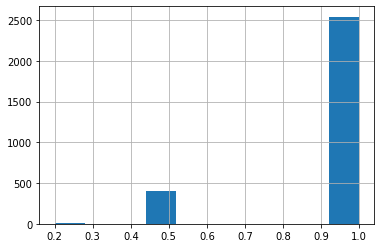

In [42]:
IMG_preds['IoU_Attributes_ID_3'].hist()

In [43]:
for i in [1,3,5,10]:
    print(IMG_preds['IoU_Places_ID_'+str(i)].describe())

count    2952.000000
mean        0.704268
std         0.456448
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IoU_Places_ID_1, dtype: float64
count    2952.000000
mean        0.636856
std         0.298426
min         0.000000
25%         0.500000
50%         0.500000
75%         1.000000
max         1.000000
Name: IoU_Places_ID_3, dtype: float64
count    2952.000000
mean        0.635542
std         0.228633
min         0.000000
25%         0.428571
50%         0.666667
75%         0.666667
max         1.000000
Name: IoU_Places_ID_5, dtype: float64
count    2952.000000
mean        0.663200
std         0.176065
min         0.000000
25%         0.538462
50%         0.666667
75%         0.818182
max         1.000000
Name: IoU_Places_ID_10, dtype: float64


<AxesSubplot:>

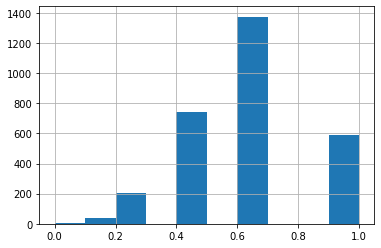

In [44]:
IMG_preds['IoU_Places_ID_5'].hist()

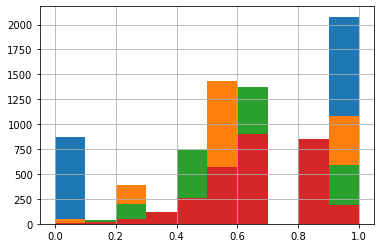

In [45]:
for i in [1,3,5,10]:
    IMG_preds['IoU_Places_ID_'+str(i)].hist()

In [76]:
for i in [1,3,5,10]:
    print(IMG_preds_S['IoU_Attributes_ID_'+str(i)].describe())

count    3137.000000
mean        0.853363
std         0.353800
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IoU_Attributes_ID_1, dtype: float64
count    3137.000000
mean        0.909850
std         0.194836
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IoU_Attributes_ID_3, dtype: float64
count    3137.000000
mean        0.842646
std         0.182020
min         0.250000
25%         0.666667
50%         1.000000
75%         1.000000
max         1.000000
Name: IoU_Attributes_ID_5, dtype: float64
count    3137.000000
mean        0.820139
std         0.139946
min         0.250000
25%         0.666667
50%         0.818182
75%         1.000000
max         1.000000
Name: IoU_Attributes_ID_10, dtype: float64


<AxesSubplot:>

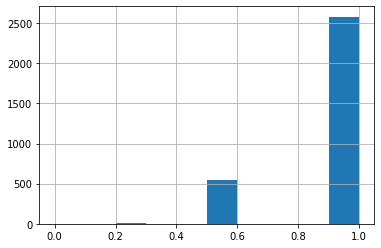

In [77]:
IMG_preds_S['IoU_Attributes_ID_3'].hist()

In [78]:
for i in [1,3,5,10]:
    print(IMG_preds_S['IoU_Places_ID_'+str(i)].describe())

count    3137.000000
mean        0.676124
std         0.468028
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IoU_Places_ID_1, dtype: float64
count    3137.000000
mean        0.623047
std         0.299022
min         0.000000
25%         0.500000
50%         0.500000
75%         1.000000
max         1.000000
Name: IoU_Places_ID_3, dtype: float64
count    3137.000000
mean        0.636213
std         0.237836
min         0.000000
25%         0.428571
50%         0.666667
75%         0.666667
max         1.000000
Name: IoU_Places_ID_5, dtype: float64
count    3137.000000
mean        0.657752
std         0.174830
min         0.111111
25%         0.538462
50%         0.666667
75%         0.818182
max         1.000000
Name: IoU_Places_ID_10, dtype: float64


<AxesSubplot:>

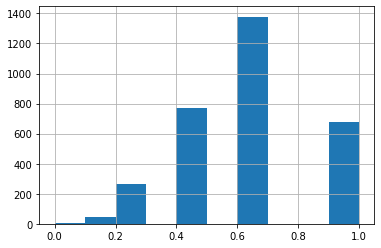

In [79]:
IMG_preds_S['IoU_Places_ID_5'].hist()

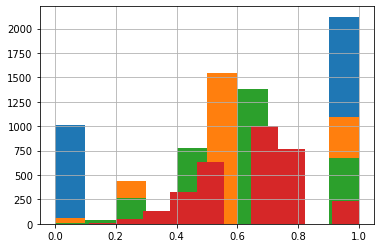

In [80]:
for i in [1,3,5,10]:
    IMG_preds_S['IoU_Places_ID_'+str(i)].hist()

In [36]:
for i in [1,3,5,10]:
    print(IMG_preds_A['IoU_Attributes_ID_'+str(i)].describe())

count    3727.000000
mean        0.867185
std         0.339420
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IoU_Attributes_ID_1, dtype: float64
count    3727.000000
mean        0.904615
std         0.198451
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IoU_Attributes_ID_3, dtype: float64
count    3727.000000
mean        0.869613
std         0.174496
min         0.428571
25%         0.666667
50%         1.000000
75%         1.000000
max         1.000000
Name: IoU_Attributes_ID_5, dtype: float64
count    3727.000000
mean        0.802698
std         0.144454
min         0.333333
25%         0.666667
50%         0.818182
75%         0.818182
max         1.000000
Name: IoU_Attributes_ID_10, dtype: float64


<AxesSubplot:>

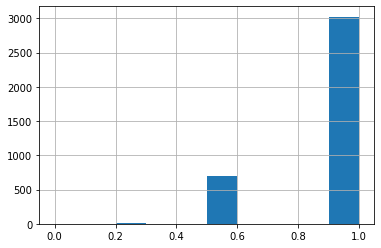

In [38]:
IMG_preds_A['IoU_Attributes_ID_3'].hist()

In [39]:
for i in [1,3,5,10]:
    print(IMG_preds_A['IoU_Places_ID_'+str(i)].describe())

count    3727.000000
mean        0.655755
std         0.475185
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: IoU_Places_ID_1, dtype: float64
count    3727.000000
mean        0.601744
std         0.301347
min         0.000000
25%         0.500000
50%         0.500000
75%         1.000000
max         1.000000
Name: IoU_Places_ID_3, dtype: float64
count    3727.000000
mean        0.614766
std         0.239837
min         0.000000
25%         0.428571
50%         0.666667
75%         0.666667
max         1.000000
Name: IoU_Places_ID_5, dtype: float64
count    3727.000000
mean        0.632943
std         0.178650
min         0.052632
25%         0.538462
50%         0.666667
75%         0.818182
max         1.000000
Name: IoU_Places_ID_10, dtype: float64


<AxesSubplot:>

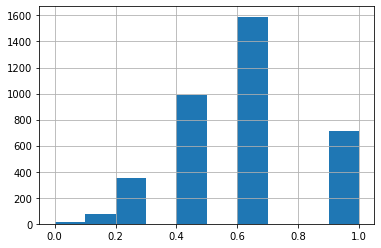

In [40]:
IMG_preds_A['IoU_Places_ID_5'].hist()

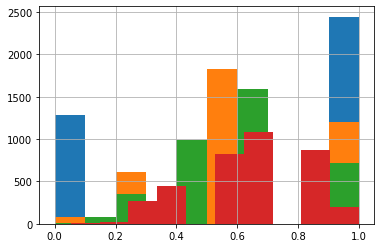

In [41]:
for i in [1,3,5,10]:
    IMG_preds_A['IoU_Places_ID_'+str(i)].hist()

In [1087]:
list(IMG_preds.keys())

['Attributes_0_x',
 'Attributes_1_x',
 'Attributes_2_x',
 'Attributes_3_x',
 'Attributes_4_x',
 'Attributes_5_x',
 'Attributes_6_x',
 'Attributes_7_x',
 'Attributes_8_x',
 'Attributes_9_x',
 'Attributes_ID_0_x',
 'Attributes_ID_1_x',
 'Attributes_ID_2_x',
 'Attributes_ID_3_x',
 'Attributes_ID_4_x',
 'Attributes_ID_5_x',
 'Attributes_ID_6_x',
 'Attributes_ID_7_x',
 'Attributes_ID_8_x',
 'Attributes_ID_9_x',
 'Places_p_0_x',
 'Places_p_1_x',
 'Places_p_2_x',
 'Places_p_3_x',
 'Places_p_4_x',
 'Places_p_5_x',
 'Places_p_6_x',
 'Places_p_7_x',
 'Places_p_8_x',
 'Places_p_9_x',
 'Places_0_x',
 'Places_1_x',
 'Places_2_x',
 'Places_3_x',
 'Places_4_x',
 'Places_5_x',
 'Places_6_x',
 'Places_7_x',
 'Places_8_x',
 'Places_9_x',
 'Places_ID_0_x',
 'Places_ID_1_x',
 'Places_ID_2_x',
 'Places_ID_3_x',
 'Places_ID_4_x',
 'Places_ID_5_x',
 'Places_ID_6_x',
 'Places_ID_7_x',
 'Places_ID_8_x',
 'Places_ID_9_x',
 'VisFeat_0_x',
 'VisFeat_1_x',
 'VisFeat_2_x',
 'VisFeat_3_x',
 'VisFeat_4_x',
 'VisFeat_

In [46]:
IMG_preds['confidence_x'] = (IMG_preds['Places_p_0_x']+IMG_preds['Places_p_1_x']+IMG_preds['Places_p_2_x']+IMG_preds['Places_p_3_x']+IMG_preds['Places_p_4_x']).astype(float)

In [47]:
IMG_preds['confidence_y'] = (IMG_preds['Places_p_0_y']+IMG_preds['Places_p_1_y']+IMG_preds['Places_p_2_y']+IMG_preds['Places_p_3_y']+IMG_preds['Places_p_4_y']).astype(float)

In [81]:
IMG_preds_S['confidence_x'] = (IMG_preds_S['Places_p_0_x']+IMG_preds_S['Places_p_1_x']+IMG_preds_S['Places_p_2_x']+IMG_preds_S['Places_p_3_x']+IMG_preds_S['Places_p_4_x']).astype(float)

In [82]:
IMG_preds_S['confidence_y'] = (IMG_preds_S['Places_p_0_y']+IMG_preds_S['Places_p_1_y']+IMG_preds_S['Places_p_2_y']+IMG_preds_S['Places_p_3_y']+IMG_preds_S['Places_p_4_y']).astype(float)

In [42]:
IMG_preds_A['confidence_x'] = (IMG_preds_A['Places_p_0_x']+IMG_preds_A['Places_p_1_x']+IMG_preds_A['Places_p_2_x']+IMG_preds_A['Places_p_3_x']+IMG_preds_A['Places_p_4_x']).astype(float)

In [43]:
IMG_preds_A['confidence_y'] = (IMG_preds_A['Places_p_0_y']+IMG_preds_A['Places_p_1_y']+IMG_preds_A['Places_p_2_y']+IMG_preds_A['Places_p_3_y']+IMG_preds_A['Places_p_4_y']).astype(float)

In [33]:
IMG_pred_150_L['confidence'] = (IMG_pred_150_L['Places_p_0']+IMG_pred_150_L['Places_p_1']+IMG_pred_150_L['Places_p_2']+IMG_pred_150_L['Places_p_3']+IMG_pred_150_L['Places_p_4']).astype(float)

C:\Users\zzbn1\AppData\Local\Temp\ipykernel_39768\3492418835.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IMG_pred_150_L['confidence'] = (IMG_pred_150_L['Places_p_0']+IMG_pred_150_L['Places_p_1']+IMG_pred_150_L['Places_p_2']+IMG_pred_150_L['Places_p_3']+IMG_pred_150_L['Places_p_4']).astype(float)


In [55]:
IMG_pred_150_T['confidence'] = (IMG_pred_150_T['Places_p_0']+IMG_pred_150_T['Places_p_1']+IMG_pred_150_T['Places_p_2']+IMG_pred_150_T['Places_p_3']+IMG_pred_150_T['Places_p_4']).astype(float)

C:\Users\zzbn1\AppData\Local\Temp\ipykernel_39768\2944083945.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  IMG_pred_150_T['confidence'] = (IMG_pred_150_T['Places_p_0']+IMG_pred_150_T['Places_p_1']+IMG_pred_150_T['Places_p_2']+IMG_pred_150_T['Places_p_3']+IMG_pred_150_T['Places_p_4']).astype(float)


In [48]:
IMG_preds['confidence_x'].describe()

count    2952.000000
mean        0.593357
std         0.208774
min         0.107235
25%         0.423004
50%         0.583660
75%         0.756112
max         0.999999
Name: confidence_x, dtype: float64

In [49]:
IMG_preds['confidence_y'].describe()

count    2952.000000
mean        0.602146
std         0.208169
min         0.128848
25%         0.433170
50%         0.591091
75%         0.767562
max         0.999973
Name: confidence_y, dtype: float64

In [84]:
IMG_preds_S['confidence_x'].describe()

count    3137.000000
mean        0.550286
std         0.222121
min         0.099642
25%         0.377057
50%         0.512306
75%         0.708934
max         0.999997
Name: confidence_x, dtype: float64

In [85]:
IMG_preds_S['confidence_y'].describe()

count    3137.000000
mean        0.559549
std         0.216690
min         0.099431
25%         0.390963
50%         0.518500
75%         0.722952
max         0.999984
Name: confidence_y, dtype: float64

In [44]:
IMG_preds_A['confidence_x'].describe()

count    3727.000000
mean        0.563179
std         0.220386
min         0.128919
25%         0.381991
50%         0.539093
75%         0.737394
max         0.999989
Name: confidence_x, dtype: float64

In [45]:
IMG_preds_A['confidence_y'].describe()

count    3727.000000
mean        0.575451
std         0.218184
min         0.106549
25%         0.398362
50%         0.550175
75%         0.747378
max         0.999993
Name: confidence_y, dtype: float64

In [34]:
IMG_pred_150_L['confidence'].describe()

count    80964.000000
mean         0.562826
std          0.214682
min          0.081697
25%          0.391465
50%          0.539141
75%          0.726966
max          1.000000
Name: confidence, dtype: float64

In [56]:
IMG_pred_150_T['confidence'].describe()

count    902.000000
mean       0.584424
std        0.206509
min        0.160659
25%        0.418200
50%        0.572415
75%        0.757369
max        0.991062
Name: confidence, dtype: float64

<AxesSubplot:>

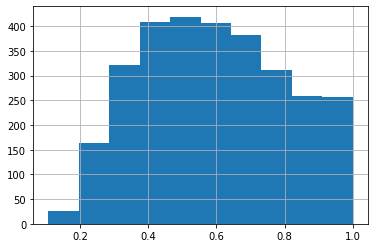

In [50]:
IMG_preds['confidence_x'].hist()

<AxesSubplot:>

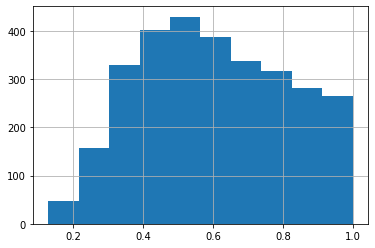

In [51]:
IMG_preds['confidence_y'].hist()

<AxesSubplot:>

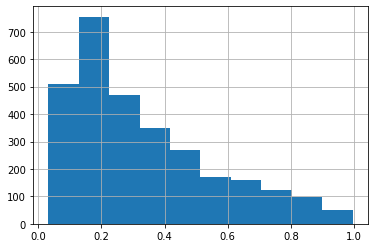

In [52]:
IMG_preds['Places_p_0_x'].hist()

<AxesSubplot:>

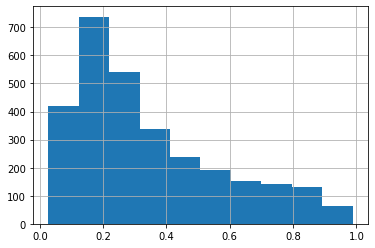

In [53]:
IMG_preds['Places_p_0_y'].hist()

<AxesSubplot:>

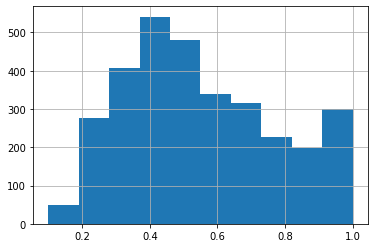

In [86]:
IMG_preds_S['confidence_x'].hist()

<AxesSubplot:>

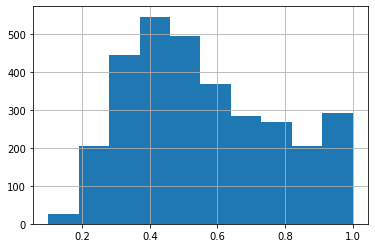

In [87]:
IMG_preds_S['confidence_y'].hist()

<AxesSubplot:>

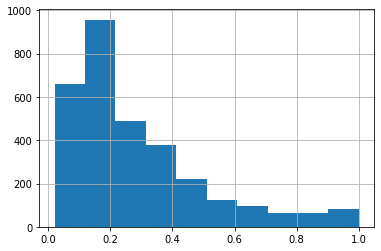

In [88]:
IMG_preds_S['Places_p_0_x'].hist()

<AxesSubplot:>

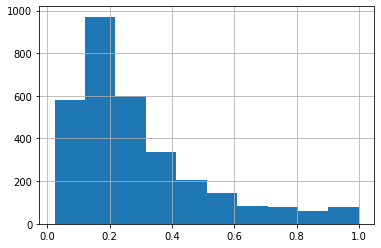

In [89]:
IMG_preds_S['Places_p_0_y'].hist()

<AxesSubplot:>

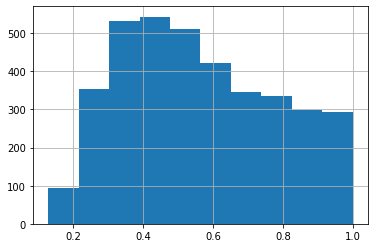

In [46]:
IMG_preds_A['confidence_x'].hist()

<AxesSubplot:>

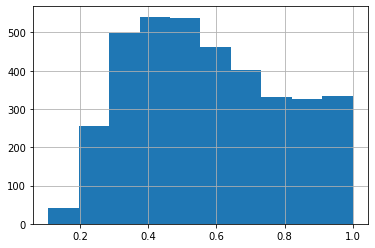

In [47]:
IMG_preds_A['confidence_y'].hist()

<AxesSubplot:>

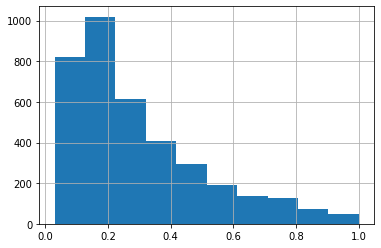

In [48]:
IMG_preds_A['Places_p_0_x'].hist()

<AxesSubplot:>

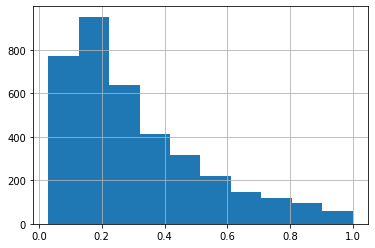

In [49]:
IMG_preds_A['Places_p_0_y'].hist()

<AxesSubplot:>

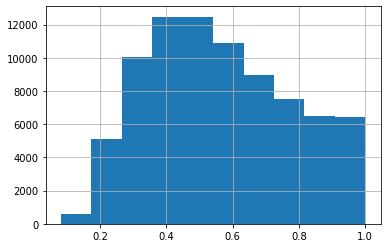

In [35]:
IMG_pred_150_L['confidence'].hist()

<AxesSubplot:>

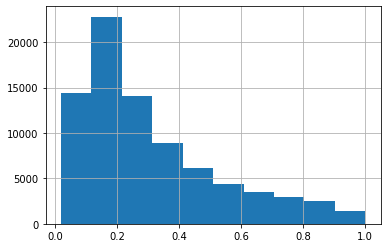

In [36]:
IMG_pred_150_L['Places_p_0'].hist()

<AxesSubplot:>

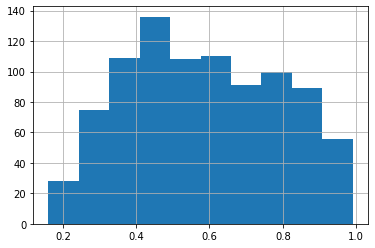

In [57]:
IMG_pred_150_T['confidence'].hist()

<AxesSubplot:>

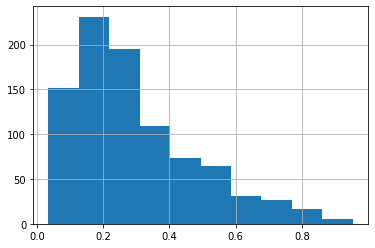

In [58]:
IMG_pred_150_T['Places_p_0'].hist()

In [54]:
IMG_preds_conf = IMG_preds[IMG_preds['confidence_x']>0.4]

In [93]:
IMG_preds_conf_S = IMG_preds_S[IMG_preds_S['confidence_x']>0.4]

In [50]:
IMG_preds_conf_A = IMG_preds_A[IMG_preds_A['confidence_x']>0.4]

In [51]:
IMG_preds_conf_A

index,Attributes_0_x,Attributes_1_x,Attributes_2_x,Attributes_3_x,Attributes_4_x,Attributes_5_x,Attributes_6_x,Attributes_7_x,Attributes_8_x,Attributes_9_x,...,IoU_Attributes_ID_1,IoU_Places_ID_1,IoU_Attributes_ID_3,IoU_Places_ID_3,IoU_Attributes_ID_5,IoU_Places_ID_5,IoU_Attributes_ID_10,IoU_Places_ID_10,confidence_x,confidence_y
ID,,,,,,,,,,,,,,,,,,,,,
4074991040,man-made,no horizon,natural light,enclosed area,open area,working,transporting,cluttered space,vertical components,driving,...,1.0,1.0,1.0,1.0,1.000000,1.000000,0.818182,0.666667,0.484733,0.832675
49286194036,no horizon,cloth,natural light,enclosed area,man-made,working,cold,open area,snow,stressful,...,1.0,1.0,0.5,1.0,0.666667,0.666667,1.000000,0.818182,0.500380,0.521544
50996941904,no horizon,natural light,man-made,aged,open area,dry,rock,dirt,dirty,rugged scene,...,1.0,1.0,1.0,0.5,0.666667,0.666667,1.000000,0.818182,0.797860,0.787475
51042706771,no horizon,enclosed area,man-made,cold,snow,sports,competing,exercise,ice,plastic,...,1.0,0.0,1.0,0.5,0.666667,1.000000,0.666667,0.538462,0.490029,0.245425
51046768633,enclosed area,no horizon,man-made,metal,indoor lighting,working,using tools,glossy,cloth,plastic,...,1.0,1.0,1.0,1.0,0.666667,0.666667,1.000000,0.666667,0.960134,0.824617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51885317441,man-made,natural light,open area,transporting,metal,railroad,sunny,asphalt,rusty,no horizon,...,1.0,1.0,1.0,1.0,1.000000,1.000000,0.666667,0.818182,0.998984,0.997983
51885929339,man-made,natural light,no horizon,open area,driving,transporting,glass,pavement,asphalt,trees,...,0.0,0.0,0.5,0.5,1.000000,0.428571,0.818182,0.666667,0.564263,0.531922
5335187703,no horizon,man-made,enclosed area,cloth,working,natural light,glass,shopping,paper,vertical components,...,1.0,1.0,1.0,1.0,0.666667,1.000000,0.818182,0.818182,0.541651,0.554388


<AxesSubplot:>

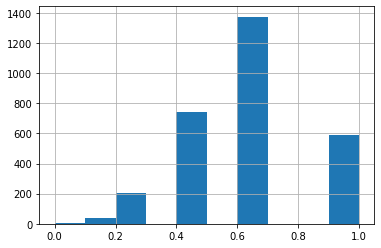

In [56]:
IMG_preds['IoU_Places_ID_5'].hist()

<AxesSubplot:>

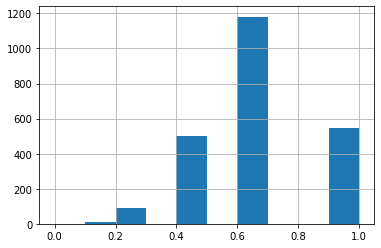

In [57]:
IMG_preds_conf['IoU_Places_ID_5'].hist()

In [1049]:
IMG_preds.to_csv('data_storage/5km/IMG_preds.csv',sep='\t')

In [1077]:
IMG_pred_150.to_csv('data_storage/5km/IMG_pred_150.csv',sep='\t')

In [58]:
IMG_preds.to_csv('Venezia/data_storage/IMG_preds.csv',sep='\t')

In [59]:
IMG_pred_150.to_csv('Venezia/data_storage/IMG_pred_150.csv',sep='\t')

In [90]:
IMG_preds_S.to_csv('Suzhou/data_storage/IMG_preds.csv',sep='\t')

In [91]:
IMG_pred_150_S.to_csv('Suzhou/data_storage/IMG_pred_150.csv',sep='\t')

In [52]:
IMG_preds_A.to_csv('Amsterdam/data_storage/IMG_preds.csv',sep='\t')

In [54]:
IMG_pred_150_A.to_csv('Amsterdam/data_storage/IMG_pred_150.csv',sep='\t')

In [37]:
IMG_pred_150_L.to_csv('data_storage/images/IMG_pred_150.csv',sep='\t')

In [60]:
IMG_pred_150_T.to_csv('Tripoli/data_storage/IMG_pred_150.csv',sep='\t')

## Demonstration on Single Example

In [842]:
pd.DataFrame(all_images)

,0
0,36296410602.jpg
1,49332180298.jpg
2,49332642536.jpg
3,49332865907.jpg
4,49817775013.jpg
...,...
2923,50766905077.jpg
2924,50770113131.jpg
2925,50770228312.jpg
2926,5224507877.jpg


In [854]:
pd.DataFrame(all_images_150)

,0
0,36296410602.jpg
1,49332180298.jpg
2,49332642536.jpg
3,49332865907.jpg
4,49817775013.jpg
...,...
2907,50766905077.jpg
2908,50770113131.jpg
2909,50770228312.jpg
2910,5224507877.jpg


In [855]:
img_name, img, input_img = get_one_image(ID = 2924, all_images=all_images, images_folder=images_folder)

In [1012]:
image_i_to_df(2924, images_folder, all_images).T['values'].tolist()

['man-made',
 'natural light',
 'no horizon',
 'open area',
 'vertical components',
 'vegetation',
 'leaves',
 'foliage',
 'sunny',
 'railing',
 88,
 74,
 93,
 89,
 95,
 42,
 45,
 44,
 75,
 37,
 0.11528534442186356,
 0.06023288518190384,
 0.05134490877389908,
 0.04067084938287735,
 0.036544207483530045,
 0.03219714015722275,
 0.026861876249313354,
 0.02640099637210369,
 0.024582844227552414,
 0.023911209776997566,
 'kennel/outdoor',
 'jail_cell',
 'roof_garden',
 'aqueduct',
 'courtyard',
 'cemetery',
 'embassy',
 'vegetable_garden',
 'arch',
 'balcony/interior',
 201,
 196,
 290,
 10,
 109,
 86,
 132,
 345,
 12,
 33,
 0.12662827968597412,
 1.5313010215759277,
 0.3048028349876404,
 0.3455573618412018,
 0.7108612656593323,
 1.0423147678375244,
 0.1999891698360443,
 1.0879111289978027,
 0.11353989690542221,
 0.7641609907150269,
 1.3952596187591553,
 0.7768016457557678,
 1.0286459922790527,
 0.4744516611099243,
 1.4531816244125366,
 0.19420288503170013,
 0.4406251013278961,
 0.54745483398

In [1013]:
report_image_i(2924)

{'TYPE OF ENVIRONMENT': 'outdoor',
 'PRED': [(0.115285344, 'kennel/outdoor', 201),
  (0.060232885, 'jail_cell', 196),
  (0.05134491, 'roof_garden', 290),
  (0.04067085, 'aqueduct', 10),
  (0.036544207, 'courtyard', 109),
  (0.03219714, 'cemetery', 86),
  (0.026861876, 'embassy', 132),
  (0.026400996, 'vegetable_garden', 345),
  (0.024582844, 'arch', 12),
  (0.02391121, 'balcony/interior', 33)],
 'SCENE ATTRIBUTES': [('man-made', 88),
  ('natural light', 74),
  ('no horizon', 93),
  ('open area', 89),
  ('vertical components', 95),
  ('vegetation', 42),
  ('leaves', 45),
  ('foliage', 44),
  ('sunny', 75),
  ('railing', 37)],
 'FEATURES': array([0.12662828, 1.531301  , 0.30480283, 0.34555736, 0.71086127,
        1.0423148 , 0.19998917, 1.0879111 , 0.1135399 , 0.764161  ,
        1.3952596 , 0.77680165, 1.028646  , 0.47445166, 1.4531816 ,
        0.19420289, 0.4406251 , 0.54745483, 1.4075545 , 0.33875677,
        0.09056262, 1.2323786 , 0.71707505, 0.27641743, 0.34903106,
        0.31309

In [1014]:
report_images([2924,1])

{'50770113131.jpg': {'TYPE OF ENVIRONMENT': 'outdoor',
  'PRED': [(0.115285344, 'kennel/outdoor', 201),
   (0.06023294, 'jail_cell', 196),
   (0.05134486, 'roof_garden', 290),
   (0.04067085, 'aqueduct', 10),
   (0.036544207, 'courtyard', 109),
   (0.03219714, 'cemetery', 86),
   (0.026861928, 'embassy', 132),
   (0.02640102, 'vegetable_garden', 345),
   (0.024582844, 'arch', 12),
   (0.023911187, 'balcony/interior', 33)],
  'SCENE ATTRIBUTES': [('man-made', 88),
   ('natural light', 74),
   ('no horizon', 93),
   ('open area', 89),
   ('vertical components', 95),
   ('vegetation', 42),
   ('leaves', 45),
   ('foliage', 44),
   ('sunny', 75),
   ('railing', 37)],
  'FEATURES': array([0.12662828, 1.531301  , 0.30480283, 0.34555736, 0.71086127,
         1.0423148 , 0.19998917, 1.0879111 , 0.1135399 , 0.764161  ,
         1.3952596 , 0.77680165, 1.028646  , 0.47445166, 1.4531816 ,
         0.19420289, 0.4406251 , 0.54745483, 1.4075545 , 0.33875677,
         0.09056262, 1.2323786 , 0.71707

In [1066]:
images_to_df([2924,1])

index,Attributes_0,Attributes_1,Attributes_2,Attributes_3,Attributes_4,Attributes_5,Attributes_6,Attributes_7,Attributes_8,Attributes_9,...,VisFeat_504,VisFeat_505,VisFeat_506,VisFeat_507,VisFeat_508,VisFeat_509,VisFeat_510,VisFeat_511,IO_type,name
ID,,,,,,,,,,,,,,,,,,,,,
50770113131,man-made,natural light,no horizon,open area,vertical components,vegetation,leaves,foliage,sunny,railing,...,0.540679,0.321217,0.050751,0.532916,0.23127,0.217987,0.800089,1.185786,outdoor,50770113131.jpg
49332180298,man-made,natural light,open area,driving,no horizon,asphalt,transporting,pavement,glass,biking,...,0.072833,1.016197,0.021861,1.420871,0.563455,0.621201,0.918499,0.483064,outdoor,49332180298.jpg


In [1142]:
img_name, img, input_img = get_one_image(ID = 2908, all_images=all_images_150, images_folder=images_folder_150)

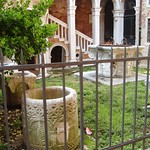

In [1143]:
display(img)

In [878]:
probs, idx = process_one_image(input_img, model)
features_blobs = features_blobs[-2:]

In [859]:
len(features_blobs)

2

In [1144]:
print('RESULT ON ' + img_name)
# output the IO prediction
io_image = np.mean(labels_IO[idx[:10]]) # vote for the indoor or outdoor
if io_image < 0.5:
    print('--TYPE OF ENVIRONMENT: indoor')
else:
    print('--TYPE OF ENVIRONMENT: outdoor')

RESULT ON 50770113131.jpg
--TYPE OF ENVIRONMENT: outdoor


In [1145]:
# output the prediction of scene category
print('--SCENE CATEGORIES:')
for i in range(0, 10):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

--SCENE CATEGORIES:
0.140 -> kennel/outdoor
0.126 -> jail_cell
0.042 -> aqueduct
0.034 -> roof_garden
0.033 -> pet_shop
0.031 -> courtyard
0.026 -> vegetable_garden
0.025 -> balcony/interior
0.019 -> porch
0.018 -> japanese_garden


In [1146]:
# output the prediction of scene category
print('--SCENE CATEGORIES:')
for i in range(0, 10):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))

--SCENE CATEGORIES:
0.140 -> kennel/outdoor
0.126 -> jail_cell
0.042 -> aqueduct
0.034 -> roof_garden
0.033 -> pet_shop
0.031 -> courtyard
0.026 -> vegetable_garden
0.025 -> balcony/interior
0.019 -> porch
0.018 -> japanese_garden


In [871]:
IMG_preds.loc['50770113131']['Places_0_x']

'arena/hockey'

In [1148]:
# output the scene attributes
responses_attribute = W_attribute.dot(features_blobs[-1][0])
idx_a = np.argsort(responses_attribute)
print('--SCENE ATTRIBUTES:')
print(', '.join([labels_attribute[idx_a[i]] for i in range(-1,-10,-1)]))

--SCENE ATTRIBUTES:
man-made, natural light, no horizon, open area, vertical components, vegetation, leaves, foliage, sunny


In [1152]:
features_blobs[-2].shape

(2, 512, 14, 14)

In [1154]:
# generate class activation mapping
print('Class activation map is saved as cam'+img_name)
CAMs = returnCAM(features_blobs[-2][0], weight_softmax, [idx[0]])

# render the CAM and output
img = cv2.imread(images_folder_150+img_name)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.4 + img * 0.5
cv2.imwrite('cam'+img_name, result)

Class activation map is saved as cam50770113131.jpg


True

In [327]:
len(features_blobs)

2